In [44]:
import os
import io
import requests
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import rocks
from astropy.coordinates import SkyCoord

from fink_utils.sso.spins import (
    estimate_sso_params,
    func_hg1g2,
    func_hg1g2_with_spin,
    spin_angle,
)
from fink_utils.sso.periods import estimate_synodic_period  # v0.21.0 or more

from scipy.optimize import least_squares
from scipy import linalg

import sys

sys.path.append("..")
import ssptools

# import seaborn as sns
# sns.set_context("poster")

In [35]:
fink_colors = ["#15284F", "#F5622E"]

# Fitting functions
adapted from existing functions in fink_utils

In [2]:
def func_sshg1g2(pha, h, g1, g2, alpha0, delta0, period, a_b, a_c, phi0):
    """Return f(H, G1, G2, R, alpha0, delta0) part of the lightcurve in mag space

    Parameters
    ----------
    pha: array-like [4, N]
        List containing [phase angle in radians, RA in radians, Dec in radians, time (jd)]
    h: float
        Absolute magnitude in mag
    G1: float
        G1 parameter (no unit)
    G2: float
        G2 parameter (no unit)
    alpha0: float
        RA of the spin (radian)
    delta0: float
        Dec of the spin (radian)
    period: float
        Spin period (days)
    a_b: float
        Equatorial axes ratio
    a_c: float
        Polar axes ratio
    phi0: float
        Initial rotation phase at reference time t0 (radian)
    t0: float
        Reference time (jd)

    Returns
    -------
    out: array of floats
        H - 2.5 log(f(G1G2)) - 2.5 log(f(spin, shape))
    """
    ph = pha[0]
    ra = pha[1]
    dec = pha[2]
    ep = pha[3]

    # TBD: For the time being, we fix the reference time
    # Time( '2022-01-01T00:00:00', format='isot', scale='utc').jd
    # Kinda middle of ZTF
    t0 = 2459580.5

    # Standard HG1G2 part: h + f(alpha, G1, G2)
    func1 = func_hg1g2(ph, h, g1, g2)

    # Spin part
    cos_aspect = spin_angle(ra, dec, alpha0, delta0)
    cos_aspect_2 = cos_aspect**2
    sin_aspect_2 = 1 - cos_aspect_2
    rot_phase = (2 * np.pi * (ep - t0) / period + phi0) % (2 * np.pi)

    # new
    # https://ui.adsabs.harvard.edu/abs/1985A%26A...149..186P/abstract
    func2 = np.sqrt(
        sin_aspect_2 * (np.cos(rot_phase) ** 2 + (a_b**2) * np.sin(rot_phase) ** 2)
        + cos_aspect_2 * a_c**2
    )
    func2 = -2.5 * np.log10(func2)

    return func1 + func2

In [3]:
def build_eqs_for_spin_shape(x, filters, ph, ra, dec, jd, rhs):
    """Build the system of equations to solve using the HG1G2 + spin model

    Parameters
    ----------
    x: list
        List of parameters to fit for
    filters: np.array
        Array of size N containing the filtername for each measurement
    ph: np.array
        Array of size N containing phase angles
    ra: np.array
        Array of size N containing the RA (radian)
    dec: np.array
        Array of size N containing the Dec (radian)
    jd: np.array
        Array of size N containing the time of the measurements (jd)
    rhs: np.array
        Array of size N containing the actual measurements (magnitude)

    Returns
    -------
    out: np.array
        Array of size N containing (model - y)

    Notes
    -----
    the input `x` should start with filter independent variables,
    that is (alpha, delta, period, a/b, a/c, phi0), followed by filter dependent variables,
    that is (H, G1, G2). For example with two bands g & r:

    ```
    x = [
        alpha, delta, period, a_b, a_c, phi0,
        h_g, g_1_g, g_2_g,
        h_r, g_1_r, g_2_r
    ]
    ```

    """
    alpha, delta, period, a_b, a_c, phi0 = x[0:6]
    filternames = np.unique(filters)

    params = x[6:]
    nparams = len(params) / len(filternames)
    assert int(nparams) == nparams, "You need to input all parameters for all bands"

    params_per_band = np.reshape(params, (len(filternames), int(nparams)))
    eqs = []
    for index, filtername in enumerate(filternames):
        mask = filters == filtername

        myfunc = (
            func_sshg1g2(
                np.vstack(
                    [
                        ph[mask].tolist(),
                        ra[mask].tolist(),
                        dec[mask].tolist(),
                        jd[mask].tolist(),
                    ]
                ),
                params_per_band[index][0],
                params_per_band[index][1],
                params_per_band[index][2],
                alpha,
                delta,
                period,
                a_b,
                a_c,
                phi0,
            )
            - rhs[mask]
        )

        eqs = np.concatenate((eqs, myfunc))

    return np.ravel(eqs)

In [4]:
def fit_spin_shape(
    magpsf_red, sigmapsf, phase, ra, dec, jd, filters, p0=None, bounds=None
):
    """Fit for spin, shape, and phase curve parameters (alpha, delta, period, a_b, a_c, phi0, t0, H^b, G_1^b, G_2^b)

    Code for quality `fit`:
    0: success
    1: bad_vals
    2: MiriadeFail
    3: RunTimError
    4: LinalgError

    Code for quality `status` (least square convergence):
    -2: failure
    -1 : improper input parameters status returned from MINPACK.
    0 : the maximum number of function evaluations is exceeded.
    1 : gtol termination condition is satisfied.
    2 : ftol termination condition is satisfied.
    3 : xtol termination condition is satisfied.
    4 : Both ftol and xtol termination conditions are satisfied.

    Typically, one would only trust status = 2 and 4.


    Parameters
    ----------
    magpsf_red: array
        Reduced magnitude, that is m_obs - 5 * np.log10('Dobs' * 'Dhelio')
    sigmapsf: array
        Error estimates on magpsf_red
    phase: array
        Phase angle [rad]
    ra: array
        Right ascension [rad]
    dec: array
        Declination [rad]
    jd: optional, array
        Observing time (JD). Required for SSHG1G2 model.
    filters: array
        Filter name for each measurement
    p0: list
        Initial guess for [H, G1, G2, R, alpha, delta]. Note that even if
        there is several bands `b`, we take the same initial guess for all (H^b, G1^b, G2^b).
    bounds: tuple of lists
        Parameters boundaries for `func_hg1g2_with_spin` ([all_mins], [all_maxs]).
        Lists should be ordered as: (H, G1, G2, R, alpha, delta). Note that even if
        there is several bands `b`, we take the same bounds for all (H^b, G1^b, G2^b).

    Returns
    -------
    outdic: dict
        Dictionary containing reduced chi2, and estimated parameters and
        error on each parameters.
    """
    if p0 is None:
        p0 = [15.0, 0.15, 0.15, np.pi, 0.0, 1, 1.05, 1.05, 0.0]

    if bounds is None:
        bounds = (
            [0, 0, 0, 1e-1, -np.pi / 2, 2.2 / 24.0, 1, 1, -np.pi / 2],
            [30, 1, 1, 2 * np.pi, np.pi / 2, 1000, 5, 5, np.pi / 2],
        )

    ufilters = np.unique(filters)

    params = ["alpha0", "delta0", "period", "a_b", "a_c", "phi0"]
    phase_params = ["H", "G1", "G2"]
    for filt in ufilters:
        phase_params_with_filt = [i + "_{}".format(str(filt)) for i in phase_params]
        params = np.concatenate((params, phase_params_with_filt))

    initial_guess = p0[3:]
    for _ in ufilters:
        initial_guess = np.concatenate((initial_guess, p0[:3]))

    lower_bounds = bounds[0][3:]
    upper_bounds = bounds[1][3:]
    for _ in ufilters:
        lower_bounds = np.concatenate((lower_bounds, bounds[0][:3]))
        upper_bounds = np.concatenate((upper_bounds, bounds[1][:3]))

    if not np.all([i == i for i in magpsf_red]):
        outdic = {"fit": 1, "status": -2}
        return outdic

    try:
        res_lsq = least_squares(
            build_eqs_for_spin_shape,
            x0=initial_guess,
            bounds=(lower_bounds, upper_bounds),
            jac="2-point",
            loss="soft_l1",
            args=(filters, phase, ra, dec, jd, magpsf_red),
        )

    except RuntimeError:
        outdic = {"fit": 3, "status": -2}
        return outdic

    popt = res_lsq.x

    # estimate covariance matrix using the jacobian
    try:
        cov = linalg.inv(res_lsq.jac.T @ res_lsq.jac)
        chi2dof = np.sum(res_lsq.fun**2) / (res_lsq.fun.size - res_lsq.x.size)
        cov *= chi2dof

        # 1sigma uncertainty on fitted parameters
        perr = np.sqrt(np.diag(cov))
    except np.linalg.LinAlgError:
        # raised if jacobian is degenerated
        outdic = {"fit": 4, "status": res_lsq.status}
        return outdic

    # For the chi2, we use the error estimate from the data directly
    chisq = np.sum((res_lsq.fun / sigmapsf) ** 2)
    chisq_red = chisq / (res_lsq.fun.size - res_lsq.x.size - 1)

    geo = spin_angle(
        ra,
        dec,
        popt[params.tolist().index("alpha0")],
        popt[params.tolist().index("delta0")],
    )
    outdic = {
        "chi2red": chisq_red,
        "min_cos_lambda": np.min(np.abs(geo)),
        "mean_cos_lambda": np.mean(np.abs(geo)),
        "max_cos_lambda": np.max(np.abs(geo)),
        "status": res_lsq.status,
        "fit": 0,
    }

    # Total RMS, and per-band
    rms = np.sqrt(np.mean(res_lsq.fun**2))
    outdic["rms"] = rms
    for filt in ufilters:
        mask = filters == filt
        outdic["rms_{}".format(filt)] = np.sqrt(np.mean(res_lsq.fun[mask] ** 2))

    median_error_phot = np.median(sigmapsf)
    outdic["median_error_phot"] = median_error_phot
    for filt in ufilters:
        mask = filters == filt
        outdic["median_error_phot_{}".format(filt)] = np.median(sigmapsf[mask])

    outdic["n_obs"] = len(phase)
    for filt in ufilters:
        mask = filters == filt
        outdic["n_obs_{}".format(filt)] = len(phase[mask])

    # in degrees
    outdic["min_phase"] = np.degrees(np.min(phase))
    for filt in ufilters:
        mask = filters == filt
        outdic["min_phase_{}".format(filt)] = np.degrees(np.min(phase[mask]))

    outdic["max_phase"] = np.degrees(np.max(phase))
    for filt in ufilters:
        mask = filters == filt
        outdic["max_phase_{}".format(filt)] = np.degrees(np.max(phase[mask]))

    for i, name in enumerate(params):
        if name in ["alpha0", "delta0"]:
            # convert in degrees
            outdic[params[i]] = np.degrees(popt[i])
            outdic["err_" + params[i]] = np.degrees(perr[i])
        else:
            outdic[params[i]] = popt[i]
            outdic["err_" + params[i]] = perr[i]

    return outdic

In [5]:
def estimate_sso_parameters(
    magpsf_red,
    sigmapsf,
    phase,
    filters,
    ra=None,
    dec=None,
    jd=None,
    model="SSHG1G2",
    normalise_to_V=False,
    p0=None,
    bounds=None,
):
    """Fit for phase curve parameters

    Under the hood, it uses a `least_square`. Along with the fitted parameters,
    we also provide flag to assess the quality of the fit:

    Code for quality `fit`:
    0: success
    1: bad_vals
    2: MiriadeFail
    3: RunTimError
    4: LinalgError

    Code for quality `status` (least square convergence):
    -2: failure
    -1 : improper input parameters status returned from MINPACK.
    0 : the maximum number of function evaluations is exceeded.
    1 : gtol termination condition is satisfied.
    2 : ftol termination condition is satisfied.
    3 : xtol termination condition is satisfied.
    4 : Both ftol and xtol termination conditions are satisfied.

    Typically, one would only trust status = 2 and 4.


    Parameters
    ----------
    magpsf_red: array
        Reduced magnitude, that is m_obs - 5 * np.log10('Dobs' * 'Dhelio')
    sigmapsf: array
        Error estimates on magpsf_red
    phase: array
        Phase angle [rad]
    filters: array
        Filter name for each measurement.
    ra: optional, array
        Right ascension [rad]. Required for SHG1G2 model.
    dec: optional, array
        Declination [rad]. Required for SHG1G2 model.
    jd: optional, array
        Observing time (JD). Required for SSHG1G2 model.
    model: str
        Parametric function. Currently supported:
            - SSHG1G2 (default)
            - SHG1G2
            - HG1G2
            - HG12
            - HG
    normalise_to_V: optional, bool
        If True, bring all bands to V. Default is False.
    p0: list
        Initial guess for input parameters. If there are several bands,
        we replicate the bounds for all. Note that in the case of SHG1G2,
        the spin parameters are fitted globally (and not per band).
    bounds: tuple of lists
        Parameters boundaries ([all_mins], [all_maxs]).
        Lists should be ordered as:
            - SSHG1G2: (H, G1, G2, R, alpha, delta, period, a_b, a_c, phi0, t0)
            - SHG1G2: (H, G1, G2, R, alpha, delta)
            - HG1G2: (H, G1, G2)
            - HG12: (H, G12)
            - HG: (H, G)
        Note that even if there is several bands `b`, we take the same
        bounds for all H's and G's.

    Returns
    -------
    outdic: dict
        Dictionary containing reduced chi2, and estimated parameters and
        error on each parameters.

    Examples
    --------
    >>> import io
    >>> import requests
    >>> import pandas as pd

    >>> r = requests.post(
    ...     'https://fink-portal.org/api/v1/sso',
    ...     json={
    ...         'n_or_d': '223',
    ...         'withEphem': True,
    ...         'output-format': 'json'
    ...     }
    ... )

    # Extract relevant information
    >>> pdf = pd.read_json(io.BytesIO(r.content))

    >>> hg = estimate_sso_params(
    ...    pdf['i:magpsf_red'].values,
    ...    pdf['i:sigmapsf'].values,
    ...    np.deg2rad(pdf['Phase'].values),
    ...    pdf['i:fid'].values,
    ...    p0=[15.0, 0.15],
    ...    bounds=([0, 0], [30, 1]),
    ...    model='HG',
    ...    normalise_to_V=False)
    >>> assert len(hg) == 26, "Found {} parameters: {}".format(len(hg), hg)

    >>> hg12 = estimate_sso_params(
    ...    pdf['i:magpsf_red'].values,
    ...    pdf['i:sigmapsf'].values,
    ...    np.deg2rad(pdf['Phase'].values),
    ...    pdf['i:fid'].values,
    ...    p0=[15.0, 0.15],
    ...    bounds=([0, 0], [30, 1]),
    ...    model='HG12',
    ...    normalise_to_V=False)
    >>> assert len(hg12) == 26, "Found {} parameters: {}".format(len(hg12), hg12)

    >>> hg1g2 = estimate_sso_params(
    ...    pdf['i:magpsf_red'].values,
    ...    pdf['i:sigmapsf'].values,
    ...    np.deg2rad(pdf['Phase'].values),
    ...    pdf['i:fid'].values,
    ...    p0=[15.0, 0.15, 0.15],
    ...    bounds=([0, 0, 0], [30, 1, 1]),
    ...    model='HG1G2',
    ...    normalise_to_V=False)
    >>> assert len(hg1g2) == 30, "Found {} parameters: {}".format(len(hg1g2), hg1g2)

    >>> shg1g2 = estimate_sso_params(
    ...    pdf['i:magpsf_red'].values,
    ...    pdf['i:sigmapsf'].values,
    ...    np.deg2rad(pdf['Phase'].values),
    ...    pdf['i:fid'].values,
    ...    np.deg2rad(pdf['i:ra'].values),
    ...    np.deg2rad(pdf['i:dec'].values),
    ...    model='SHG1G2',
    ...    normalise_to_V=False)
    >>> assert len(shg1g2) == 39, "Found {} parameters: {}".format(len(shg1g2), shg1g2)

    # You can also combine data into single V band
    >>> shg1g2 = estimate_sso_params(
    ...    pdf['i:magpsf_red'].values,
    ...    pdf['i:sigmapsf'].values,
    ...    np.deg2rad(pdf['Phase'].values),
    ...    pdf['i:fid'].values,
    ...    np.deg2rad(pdf['i:ra'].values),
    ...    np.deg2rad(pdf['i:dec'].values),
    ...    model='SHG1G2',
    ...    normalise_to_V=True)
    >>> assert len(shg1g2) == 28, "Found {} parameters: {}".format(len(shg1g2), shg1g2)

    # If you enter a wrong model name, raise an error
    >>> wrong = estimate_sso_params(
    ...    pdf['i:magpsf_red'].values,
    ...    pdf['i:sigmapsf'].values,
    ...    np.deg2rad(pdf['Phase'].values),
    ...    pdf['i:fid'].values,
    ...    np.deg2rad(pdf['i:ra'].values),
    ...    np.deg2rad(pdf['i:dec'].values),
    ...    model='toto',
    ...    normalise_to_V=True) # doctest: +IGNORE_EXCEPTION_DETAIL
    Traceback (most recent call last):
    AssertionError: model toto is not understood. Please choose among: SHG1G2, HG1G2, HG12, HG
    """
    if p0 is None:
        p0 = [15.0, 0.15, 0.15, np.pi, 0.0, 1, 1.05, 1.05, 0.0]

    if bounds is None:
        bounds = (
            [0, 0, 0, 1e-1, -np.pi / 2, 2.2 / 24.0, 1, 1, -np.pi / 2],
            [30, 1, 1, 2 * np.pi, np.pi / 2, 1000, 5, 5, np.pi / 2],
        )

    if normalise_to_V:
        color = compute_color_correction(filters)
        ydata = magpsf_red + color
        filters = np.array(["V"] * len(filters))
    else:
        ydata = magpsf_red

    if model == "SSHG1G2":
        outdic = fit_spin_shape(
            ydata, sigmapsf, phase, ra, dec, jd, filters, p0=p0, bounds=bounds
        )
    elif model == "SHG1G2":
        outdic = fit_spin(
            ydata, sigmapsf, phase, ra, dec, filters, p0=p0, bounds=bounds
        )
    elif model in ["HG", "HG12", "HG1G2"]:
        outdic = fit_legacy_models(
            ydata, sigmapsf, phase, filters, model, p0=p0, bounds=bounds
        )
    else:
        raise AssertionError(
            "model {} is not understood. Please choose among: SHG1G2, HG1G2, HG12, HG".format(
                model
            )
        )

    return outdic

In [6]:
cols = [
    "sso_number",
    "sso_name",
    "sso_class",
    "spins.1.period.value",
    "spins.2.period.value",
]

bft = rocks.load_bft(columns=cols)

## Period estimation

In [7]:
# ssnamenr = 5209 # lotta obs, high RMS sHG1G2
# ssnamenr = 1437 # lotta obs, high RMS sHG1G2
# ssnamenr = 4209 # lotta obs, high RMS sHG1G2
# ssnamenr = 91065  # limited obs, high RMS sHG1G2

# ssnamenr = 3753 # NEA with rotation period unknown -- fail
# ssnamenr = 105140 # NEA with lotta obs

# ssnamenr = 265 # Phocaea
# ssnamenr = 136108  # KBO = fixed = Haumea
ssnamenr = 186153  # High frequency observation
# ssnamenr = 223 # Example article
ssnamenr = 9799  # JTO lotta obs

nam_num = rocks.identify(ssnamenr)

In [8]:
flavor = "SHG1G2"


period_range = (1 / 24, 7)  # 1hour to 7 days

t0, t1 = 1, 1

t0 = time.time()
period, chi2red, frequency, power, model, pdf = estimate_synodic_period(
    ssnamenr,
    flavor=flavor,
    Nterms_base=1,
    period_range=period_range,
    return_extra_info=True,
)
t1 = time.time()

print(
    "[{:.2f} seconds] model={}: period={:.2f} hours -- BFT: period={:.2f} hours".format(
        t1 - t0,
        flavor,
        period,
        # chi2red,
        bft[bft["sso_name"] == nam_num[0]]["spins.1.period.value"].values[0],
    )
)

from erfa import ErfaWarning

 [astropy.utils.exceptions]


[16.88 seconds] model=SHG1G2: period=21.73 hours -- BFT: period=21.52 hours


# Phase parameters

In [9]:
# H G1 G2 estimate
fit_shg1g2 = estimate_sso_params(
    pdf["i:magpsf_red"],
    pdf["i:sigmapsf"],
    np.radians(pdf["Phase"]),
    pdf["i:fid"],
    ra=np.radians(pdf["i:ra"]),
    dec=np.radians(pdf["i:dec"]),
    model="SHG1G2",
)

## Residuals

Text(0, 0.5, 'Residual (mag)')

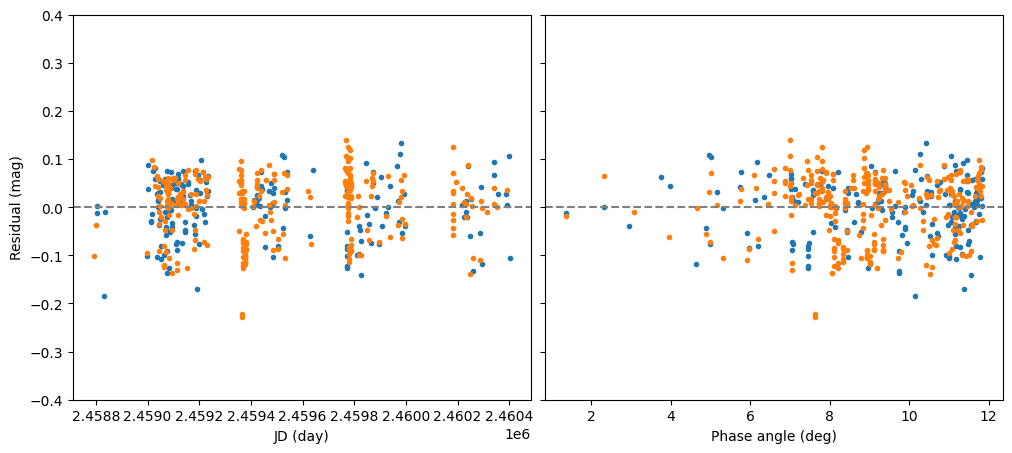

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True, gridspec_kw={"wspace": 0.03})

for filtnum in pdf["i:fid"].unique():
    cond = pdf["i:fid"] == filtnum
    ax[0].plot(pdf["i:jd"][cond], pdf["residuals"][cond], ls="", marker=".")
    ax[1].plot(pdf["Phase"][cond], pdf["residuals"][cond], ls="", marker=".")

ax[0].axhline(0, ls="--", color="grey")
ax[1].axhline(0, ls="--", color="grey")

max_res = 0.4
ax[0].set_ylim(-max_res, max_res)
ax[0].set_xlabel("JD (day)")
ax[1].set_xlabel("Phase angle (deg)")
ax[0].set_ylabel("Residual (mag)")

## ssHG1G2

In [11]:
# Initial guess
p0 = [
    fit_shg1g2["H_1"],
    fit_shg1g2["G1_1"],
    fit_shg1g2["G2_1"],
    np.radians(fit_shg1g2["alpha0"]),
    np.radians(fit_shg1g2["delta0"]),
    period * 2 / 24,  # Rotation in days (2* LS value: double-peaked lightcurve)
    1.05,
    1.05,
    0.0,
]

# Constrained Fit
fit_sshg1g2 = estimate_sso_parameters(
    pdf["i:magpsf_red"],
    pdf["i:sigmapsf"],
    np.radians(pdf["Phase"]),
    pdf["i:fid"],
    ra=np.radians(pdf["i:ra"]),
    dec=np.radians(pdf["i:dec"]),
    jd=pdf["i:jd"],
    model="SSHG1G2",
    p0=p0,
)

In [12]:
fit_shg1g2.keys()

dict_keys(['chi2red', 'min_cos_lambda', 'mean_cos_lambda', 'max_cos_lambda', 'status', 'fit', 'rms', 'rms_1', 'rms_2', 'median_error_phot', 'median_error_phot_1', 'median_error_phot_2', 'n_obs', 'n_obs_1', 'n_obs_2', 'min_phase', 'min_phase_1', 'min_phase_2', 'max_phase', 'max_phase_1', 'max_phase_2', 'R', 'err_R', 'alpha0', 'err_alpha0', 'delta0', 'err_delta0', 'H_1', 'err_H_1', 'G1_1', 'err_G1_1', 'G2_1', 'err_G2_1', 'H_2', 'err_H_2', 'G1_2', 'err_G1_2', 'G2_2', 'err_G2_2'])

In [13]:
print("       sHG1G2  ssHG1G2")
print(f"RMS  : {fit_shg1g2['rms']:6.3f}  {fit_sshg1g2['rms']:6.3f}")
print()
print(f"H1   : {fit_shg1g2['H_1']:6.2f}  {fit_sshg1g2['H_1']:6.2f}")
print(f" G1_1: {fit_shg1g2['G1_1']:6.2f}  {fit_sshg1g2['G1_1']:6.2f}")
print(f" G2_1: {fit_shg1g2['G2_1']:6.2f}  {fit_sshg1g2['G2_1']:6.2f}")
print(f"H2   : {fit_shg1g2['H_2']:6.2f}  {fit_sshg1g2['H_2']:6.2f}")
print(f" G1_2: {fit_shg1g2['G1_2']:6.2f}  {fit_sshg1g2['G1_2']:6.2f}")
print(f" G2_2: {fit_shg1g2['G2_2']:6.2f}  {fit_sshg1g2['G2_2']:6.2f}")

print()
print(f"RA0  : {fit_shg1g2['alpha0']:6.1f}  {fit_sshg1g2['alpha0']:6.1f}")
print(f"DEC0 : {fit_shg1g2['delta0']:6.1f}  {fit_sshg1g2['delta0']:6.1f}")
print(f"P(h) : {2*period:6.3f}  {fit_sshg1g2['period']*24:6.3f}")
print(f"abc  : {fit_sshg1g2['a_b']:6.2f}  {fit_sshg1g2['a_c']:6.2f}")

root = f"{nam_num[1]}_{nam_num[0]}".replace(" ", "_")
with open(os.path.join("..", "..", "gfx", "ssHG1G2", f"{root}.csv"), "w") as f:
    f.write(f"par,sHG1G2,ssHG1G2\n")
    f.write(f"RMS,{fit_shg1g2['rms']},{fit_sshg1g2['rms']}\n")

    f.write(f"H_1,{fit_shg1g2['H_1']},{fit_sshg1g2['H_1']}\n")
    f.write(f"err_H_1,{fit_shg1g2['err_H_1']},{fit_sshg1g2['err_H_1']}\n")
    f.write(f"G1_1,{fit_shg1g2['G1_1']},{fit_sshg1g2['G1_1']}\n")
    f.write(f"G2_1,{fit_shg1g2['G2_1']},{fit_sshg1g2['G2_1']}\n")
    f.write(f"err_G1_1,{fit_shg1g2['err_G1_1']},{fit_sshg1g2['err_G1_1']}\n")
    f.write(f"err_G2_1,{fit_shg1g2['err_G2_1']},{fit_sshg1g2['err_G2_1']}\n")

    f.write(f"H_2,{fit_shg1g2['H_2']},{fit_sshg1g2['H_2']}\n")
    f.write(f"err_H_2,{fit_shg1g2['err_H_2']},{fit_sshg1g2['err_H_2']}\n")
    f.write(f"G1_2,{fit_shg1g2['G1_2']},{fit_sshg1g2['G1_2']}\n")
    f.write(f"G2_2,{fit_shg1g2['G2_2']},{fit_sshg1g2['G2_2']}\n")
    f.write(f"err_G1_2,{fit_shg1g2['err_G1_2']},{fit_sshg1g2['err_G1_2']}\n")
    f.write(f"err_G2_2,{fit_shg1g2['err_G2_2']},{fit_sshg1g2['err_G2_2']}\n")

    f.write(f"alpha0,{fit_shg1g2['alpha0']},{fit_sshg1g2['alpha0']}\n")
    f.write(f"delta0,{fit_shg1g2['delta0']},{fit_sshg1g2['delta0']}\n")
    f.write(f"err_alpha0,{fit_shg1g2['err_alpha0']},{fit_sshg1g2['err_alpha0']}\n")
    f.write(f"err_delta0,{fit_shg1g2['err_delta0']},{fit_sshg1g2['err_delta0']}\n")

    f.write(f"P,{2*period},{fit_sshg1g2['period']*24}\n")
    f.write(f"a_b,,{fit_sshg1g2['a_b']}\n")
    f.write(f"a_c,,{fit_sshg1g2['a_c']}\n")
    f.write(f"err_P,{2*period},{fit_sshg1g2['err_period']*24}\n")
    f.write(f"err_a_b,,{fit_sshg1g2['err_a_b']}\n")
    f.write(f"err_a_c,,{fit_sshg1g2['err_a_c']}\n")

       sHG1G2  ssHG1G2
RMS  :  0.063   0.045

H1   :  10.34   10.36
 G1_1:   0.99    0.87
 G2_1:   0.00    0.07
H2   :   9.61    9.84
 G1_2:   0.49    0.90
 G2_2:   0.27    0.10

RA0  :  215.2   210.8
DEC0 :   28.3    29.1
P(h) : 43.454  43.452
abc  :   1.14    1.20


In [14]:
# --------------------------------------------------------------------------------
# Compute residuals
for filtnum in pdf["i:fid"].unique():

    # Input variables
    cond = pdf["i:fid"] == filtnum

    coord = SkyCoord(
        ra=pdf.loc[cond, "i:ra"], dec=pdf.loc[cond, "i:dec"], unit=("deg", "deg")
    )
    data_ra = coord.ra.rad
    data_dec = coord.dec.rad
    data_jd = pdf.loc[cond, "i:jd"]
    data_phase = np.radians(pdf.loc[cond, "Phase"])
    data_mag = pdf.loc[cond, "i:magpsf_red"]

    pha = [data_phase.values, data_ra, data_dec, data_jd.values]

    # ssHG1G2
    model = func_sshg1g2(
        pha,
        fit_sshg1g2[f"H_{filtnum}"],
        fit_sshg1g2[f"G1_{filtnum}"],
        fit_sshg1g2[f"G2_{filtnum}"],
        np.radians(fit_sshg1g2["alpha0"]),
        np.radians(fit_sshg1g2["delta0"]),
        fit_sshg1g2["period"],
        fit_sshg1g2["a_b"],
        fit_sshg1g2["a_c"],
        fit_sshg1g2["phi0"],
    )

    pdf.loc[cond, f"res_ssHG1G2"] = data_mag - model

/tmp/ipykernel_12470/424226278.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


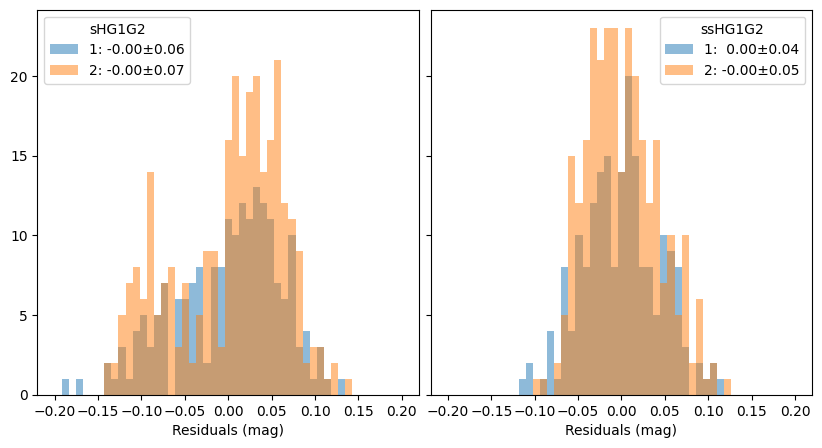

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True, gridspec_kw={"wspace": 0.03})

max_res = 0.2
bins = np.linspace(-max_res, max_res, 50)
for filtnum in pdf["i:fid"].unique():
    cond = pdf["i:fid"] == filtnum
    mu, std = np.mean(pdf.loc[cond, "residuals"]), np.std(pdf.loc[cond, "residuals"])
    ax[0].hist(
        pdf.loc[cond, "residuals"],
        bins=bins,
        alpha=0.5,
        label=f"{filtnum}: {mu:5.2f}±{std:.2f}",
    )

    mu, std = np.mean(pdf.loc[cond, "res_ssHG1G2"]), np.std(
        pdf.loc[cond, "res_ssHG1G2"]
    )
    ax[1].hist(
        pdf.loc[cond, "res_ssHG1G2"],
        bins=bins,
        alpha=0.5,
        label=f"{filtnum}: {mu:5.2f}±{std:.2f}",
    )


ax[0].legend(loc="upper left", title="sHG1G2")
ax[1].legend(loc="upper right", title="ssHG1G2")

for a in ax:
    a.set_xlabel("Residuals (mag)")

fig.tight_layout()
fig.savefig(
    os.path.join("..", "..", "gfx", "ssHG1G2", f"{root}_res_hist.png"),
    dpi=180,
    facecolor="white",
)

/tmp/ipykernel_12470/1431059566.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


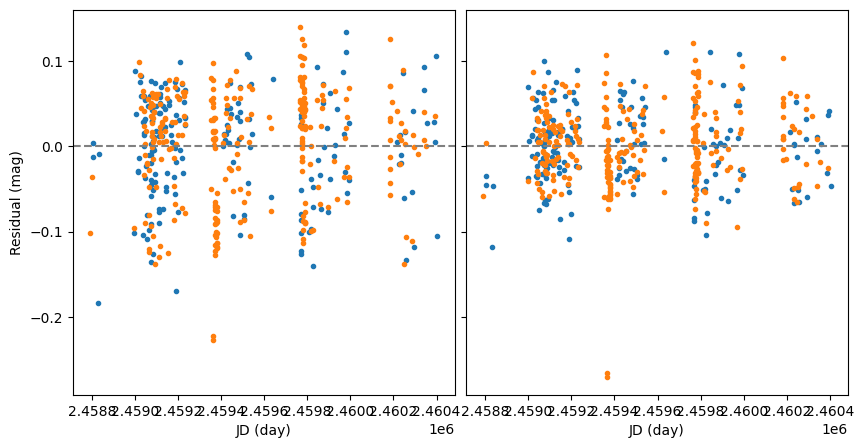

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True, gridspec_kw={"wspace": 0.03})

for filtnum in pdf["i:fid"].unique():
    cond = pdf["i:fid"] == filtnum
    ax[0].scatter(
        pdf["i:jd"][cond], pdf["residuals"][cond], marker=".", label=f"{filtnum}"
    )
    ax[1].scatter(
        pdf["i:jd"][cond], pdf["res_ssHG1G2"][cond], marker=".", label=f"{filtnum}"
    )

ax[0].axhline(0, ls="--", color="grey")
ax[1].axhline(0, ls="--", color="grey")

# max_res = 0.4
# ax[0].set_ylim(-max_res, max_res)
ax[0].set_xlabel("JD (day)")
ax[1].set_xlabel("JD (day)")
ax[0].set_ylabel("Residual (mag)")

fig.tight_layout()
fig.savefig(
    os.path.join("..", "..", "gfx", "ssHG1G2", f"{root}_res_jd.png"),
    dpi=180,
    facecolor="white",
)

/tmp/ipykernel_12470/1051417430.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


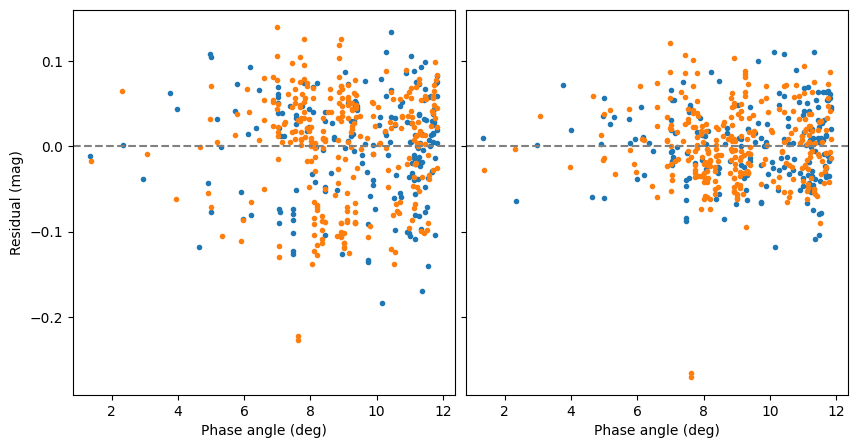

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True, gridspec_kw={"wspace": 0.03})

for filtnum in pdf["i:fid"].unique():
    cond = pdf["i:fid"] == filtnum
    ax[0].scatter(
        pdf["Phase"][cond], pdf["residuals"][cond], marker=".", label=f"{filtnum}"
    )
    ax[1].scatter(
        pdf["Phase"][cond], pdf["res_ssHG1G2"][cond], marker=".", label=f"{filtnum}"
    )

ax[0].axhline(0, ls="--", color="grey")
ax[1].axhline(0, ls="--", color="grey")

ax[0].set_xlabel("Phase angle (deg)")
ax[1].set_xlabel("Phase angle (deg)")
ax[0].set_ylabel("Residual (mag)")

fig.tight_layout()
fig.savefig(
    os.path.join("..", "..", "gfx", "ssHG1G2", f"{root}_res_phase.png"),
    dpi=180,
    facecolor="white",
)

/tmp/ipykernel_12470/2036458346.py:250: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


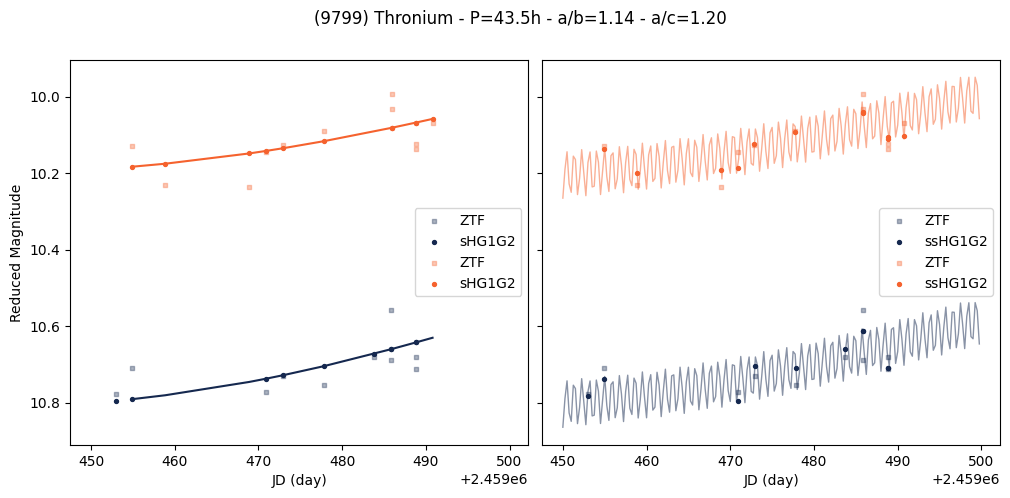

In [70]:
match ssnamenr:
    case 223:  # Example from article
        jd0 = 2459800
        t0 = jd0
        len_day = 30
        eph_large, eph_small = True, True
        jd1 = jd0 + 10
        step = "2h"
        nbd = 200

    case 186153:  # Example with high frequency observations
        jd0 = 2_460_495.550
        t0 = 2_460_495.50
        len_day = 1
        eph_large, eph_small = False, True
        jd1 = jd0
        step = "10m"
        nbd = 74

    case 136108:  # KBO slow mo
        jd0 = 2_460_050.5
        t0 = jd0
        len_day = 5
        eph_large, eph_small = True, True
        jd1 = jd0
        step = "10min"
        nbd = 700

    case 9799:  # JTO Thronium
        jd0 = 2_459_350
        t0 = jd0
        len_day = 30

        jd0 = 2_459_450
        t0 = jd0
        len_day = 50

        eph_large, eph_small = True, False
        jd1 = jd0
        step = "10min"
        nbd = 700

    case _:
        jd0 = 2_460_200.0
        t0 = jd0
        len_day = 100
        eph_large, eph_small = False, False
        jd1 = jd0
        step = "1h"
        nbd = 24


# --------------------------------------------------------------------------------
# Build independent variables
cond_jd = (pdf["i:jd"] > jd0) & (pdf["i:jd"] < jd0 + len_day)


fig, ax = plt.subplots(
    1, 2, figsize=(12, 5), sharex=True, sharey=True, gridspec_kw={"wspace": 0.03}
)


# --------------------------------------------------------------------------------
# ssHG1G2
for i, filtnum in enumerate(pdf["i:fid"].unique()):

    # Input variables
    cond = cond_jd & (pdf["i:fid"] == filtnum)

    coord = SkyCoord(
        ra=pdf.loc[cond, "i:ra"], dec=pdf.loc[cond, "i:dec"], unit=("deg", "deg")
    )
    data_ra = coord.ra.rad
    data_dec = coord.dec.rad
    data_jd = pdf.loc[cond, "i:jd"]
    data_phase = np.radians(pdf.loc[cond, "Phase"])
    data_mag = pdf.loc[cond, "i:magpsf_red"]

    pha = [data_phase.values, data_ra, data_dec, data_jd.values]

    # DATA
    ax[0].scatter(
        data_jd,
        data_mag,
        marker="s",
        s=8,
        alpha=0.35,
        color=fink_colors[i],
        label="ZTF",
    )
    ax[1].scatter(
        data_jd,
        data_mag,
        marker="s",
        s=8,
        alpha=0.35,
        color=fink_colors[i],
        label="ZTF",
    )


    # sHG1G2
    model = func_hg1g2_with_spin(
        pha,
        fit_shg1g2[f"H_{filtnum}"],
        fit_shg1g2[f"G1_{filtnum}"],
        fit_shg1g2[f"G2_{filtnum}"],
        fit_shg1g2["R"],
        np.radians(fit_shg1g2["alpha0"]),
        np.radians(fit_shg1g2["delta0"]),
    )
    ax[0].scatter(
        data_jd,
        model,
        marker="o",
        s=8,
        alpha=1,
        color=fink_colors[i],
        label="sHG1G2",
    )

    # ssHG1G2
    model = func_sshg1g2(
        pha,
        fit_sshg1g2[f"H_{filtnum}"],
        fit_sshg1g2[f"G1_{filtnum}"],
        fit_sshg1g2[f"G2_{filtnum}"],
        np.radians(fit_sshg1g2["alpha0"]),
        np.radians(fit_sshg1g2["delta0"]),
        fit_sshg1g2["period"],
        fit_sshg1g2["a_b"],
        fit_sshg1g2["a_c"],
        fit_sshg1g2["phi0"],
    )

    
    ax[1].scatter(
        data_jd,
        model,
        marker="o",
        s=8,
        alpha=1,
        color=fink_colors[i],
        label="ssHG1G2",
    )

# ax[1].scatter(data_phase, data_mag, ls="", marker=".", label="ZTF")
# ax[1].scatter(data_phase, model, ls="", marker=".", label="Model")
ax[0].set_xlabel("JD (day)")
ax[1].set_xlabel("JD (day)")
ax[0].set_ylabel("Reduced Magnitude")


# --------------------------------------------------------------------------------
# Long term behavior
if eph_large:
    eph = ssptools.ephemcc(ssnamenr, ep=jd0, step="6h", nbd=len_day*4)
    f = 5 * np.log10(eph.Dobs * eph.Dhelio)

    coord = SkyCoord(ra=eph["RA"], dec=eph["DEC"], unit=("hour", "deg"))
    eph_ra = coord.ra.rad
    eph_dec = coord.dec.rad
    eph_phase = np.radians(eph["Phase"])
    eph_jd = eph["Date"]
    pha_eph = [eph_phase.values, eph_ra, eph_dec, eph_jd.values]

    for i, filtnum in enumerate(pdf["i:fid"].unique()):

        # sHG1G2
        model_eph = func_hg1g2_with_spin(
            pha,
            fit_shg1g2[f"H_{filtnum}"],
            fit_shg1g2[f"G1_{filtnum}"],
            fit_shg1g2[f"G2_{filtnum}"],
            fit_shg1g2["R"],
            np.radians(fit_shg1g2["alpha0"]),
            np.radians(fit_shg1g2["delta0"]),
        )
        ax[0].plot(
            data_jd,
            model_eph,
            ls="solid",
            color=fink_colors[i],
            # label=f"sHG1G2 {filtnum}",
        )

        # ssHG1G2
        model_eph = func_sshg1g2(
            pha_eph,
            fit_sshg1g2[f"H_{filtnum}"],
            fit_sshg1g2[f"G1_{filtnum}"],
            fit_sshg1g2[f"G2_{filtnum}"],
            np.radians(fit_sshg1g2["alpha0"]),
            np.radians(fit_sshg1g2["delta0"]),
            fit_sshg1g2["period"],
            fit_sshg1g2["a_b"],
            fit_sshg1g2["a_c"],
            fit_sshg1g2["phi0"],
        )

        ax[1].plot(
            eph_jd,
            model_eph,
            ls="solid",
            linewidth=1,
            alpha=0.5,
            color=fink_colors[i],
            # label=f"ssHG1G2 {filtnum}",
        )


# --------------------------------------------------------------------------------
# Short term behavior
if eph_small:
    eph2 = ssptools.ephemcc(ssnamenr, ep=jd1, step=step, nbd=nbd)
    f = 5 * np.log10(eph2.Dobs * eph2.Dhelio)

    coord = SkyCoord(ra=eph2["RA"], dec=eph2["DEC"], unit=("hour", "deg"))
    eph2_ra = coord.ra.rad
    eph2_dec = coord.dec.rad
    eph2_phase = np.radians(eph2["Phase"])
    eph2_jd = eph2["Date"]
    pha_eph2 = [eph2_phase.values, eph2_ra, eph2_dec, eph2_jd.values]

    model_eph2 = func_sshg1g2(
        pha_eph2,
        fit_sshg1g2[f"H_{filtnum}"],
        fit_sshg1g2[f"G1_{filtnum}"],
        fit_sshg1g2[f"G2_{filtnum}"],
        np.radians(fit_sshg1g2["alpha0"]),
        np.radians(fit_sshg1g2["delta0"]),
        fit_sshg1g2["period"],
        fit_sshg1g2["a_b"],
        fit_sshg1g2["a_c"],
        fit_sshg1g2["phi0"],
    )
    ax[0].plot(eph2_jd, model_eph2, ls="--", alpha=0.5, color="C1", label="ST")
    ax[1].plot(eph2_phase, model_eph2, ls="--", alpha=0.5, color="C1", label="ST")

for a in ax:
    # a.legend()
    a.yaxis.set_inverted(True)

ax[0].legend(loc='best')
ax[1].legend(loc='best')
fig.suptitle(
    f"({nam_num[1]}) {nam_num[0]} - P={fit_sshg1g2['period']*24:.1f}h - a/b={fit_sshg1g2['a_b']:.2f} - a/c={fit_sshg1g2['a_c']:.2f}"
)

fig.tight_layout()
fig.savefig(
    os.path.join("..", "..", "gfx", "ssHG1G2", f"{root}_comparison.png"),
    dpi=180,
    facecolor="white",
)

In [23]:
ssnamenr
# h, g1, g2, R, alpha0, delta0)

9799